In [5]:
import sys
import os
sys.path.append(os.path.abspath('..'))
import argparse
import os
import random
import shutil
import time
import warnings
import json
import re
import copy

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim
import torch.utils.data
import torch.utils.data.distributed
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms


from utils.model_analysis_nets import LeNet, VGG16, ResNet20
from utils.load import getGradients, getTotalLength, initDataset, minimizeProduct
from utils.load import getSamples, getTopofeature, extractWeights
from utils.pcode import mergeSublistsWithSharedItems
from CKA import linear_CKA, kernel_CKA
import perscode

import numpy as np
import sympy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, fclusterdata
import scipy
import networkx as nx
import gif

from sklearn.manifold import MDS

import gudhi as gd
from ripser import Rips
from datetime import datetime


from sklearn.neighbors import KernelDensity
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import MDS

In [2]:
trans_mnist = transforms.Compose([transforms.ToTensor(),
                                  transforms.Normalize((0.1307,), (0.3081,))])
trans_cifar10_val = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                             std=[0.229, 0.224, 0.225])])
dataset_test = datasets.CIFAR10('../data/cifar10/', train=False, download=True, transform=trans_cifar10_val)
test_loader = torch.utils.data.DataLoader(
                dataset_test, batch_size=32,
                num_workers=2, pin_memory=True, shuffle=False)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
colors = ['r', 'g', 'b', 'y', 'p']


Files already downloaded and verified
cuda


In [3]:

# attack_pth = "./LG-FedAvg/save_attack_ub/cifar10/resnet20_iidTrue_num100_C0.8_le2_DBATrue/shard2/pattern09-24--21-13-11/local_attack_save/"
# normal_pth = "./LG-FedAvg/save_attack_ub/cifar10/resnet20_iidTrue_num100_C0.8_le2_DBATrue/shard2/pattern09-24--21-13-11/local_normal_save/"
attack_pth = "/mnt/sda3/docker_space/Code/PHTDA-Net/LG-FedAvg/save_attack_ub/cifar10/resnet20_iidTrue_num100_C0.8_le2_DBATrue/shard2/pattern12-16--19-06-13/local_attack_save/"
normal_pth = "/mnt/sda3/docker_space/Code/PHTDA-Net/LG-FedAvg/save_attack_ub/cifar10/resnet20_iidTrue_num100_C0.8_le2_DBATrue/shard2/pattern12-16--19-06-13/local_normal_save/"
global_pth = "/mnt/sda3/docker_space/Code/PHTDA-Net/LG-FedAvg/save_attack_ub/cifar10/resnet20_iidTrue_num100_C0.8_le2_DBATrue/shard2/pattern12-16--19-06-13/fed/"

round_set = []
client_set_attack = []
client_set_normal = []
modelpth_set = []
gmodelpth_set = []
for dirpath, dirnames, filenames in os.walk(attack_pth):
    for filename in filenames:
        # if int(re.findall(r'-?\d+', filename)[0]) < round_max and int(re.findall(r'-?\d+', filename)[1]) < client_max:
        modelpth_set.append(os.path.join(dirpath, filename).replace("\\","/"))
        round_set.append(int(re.findall(r'-?\d+', filename)[0]))
        client_set_attack.append(int(re.findall(r'-?\d+', filename)[1]))

round_set = list(set(round_set))
round_set.sort(reverse=True)
client_set_attack = list(set(client_set_attack))

for dirpath, dirnames, filenames in os.walk(normal_pth):
    for filename in filenames:
        # if int(re.findall(r'-?\d+', filename)[0]) < round_max and int(re.findall(r'-?\d+', filename)[1]) < client_max:
        modelpth_set.append(os.path.join(dirpath, filename).replace("\\","/"))
        client_set_normal.append(int(re.findall(r'-?\d+', filename)[1]))

client_set_normal = list(set(client_set_normal))

for dirpath, dirnames, filenames in os.walk(global_pth):
    for filename in filenames:
        # if int(re.findall(r'-?\d+', filename)[0]) < round_max and int(re.findall(r'-?\d+', filename)[1]) < client_max:
        gmodelpth_set.append(os.path.join(dirpath, filename).replace("\\","/")) if "model" in filename else None

print("rounds", round_set, len(round_set))
print("attack", client_set_attack, len(client_set_attack))
print("normal", client_set_normal, len(client_set_normal))
print(len(modelpth_set))
print(len(gmodelpth_set))


modelpth_dict = {}
for idx, r in enumerate(round_set):
    current_set_normal = []
    current_set_attack = []
    for mt in modelpth_set:
        # print(mt)
        if int(re.findall(r'-?\d+', mt)[-2]) == r and int(re.findall(r'-?\d+', mt)[-1]) in client_set_normal:
            # print(int(re.findall(r'-?\d+', mt)[-1]))
            current_set_normal.append(mt)
        if int(re.findall(r'-?\d+', mt)[-2]) == r and int(re.findall(r'-?\d+', mt)[-1]) in client_set_attack:
            # print(int(re.findall(r'-?\d+', mt)[-1]))
            current_set_attack.append(mt)
        
    modelpth_dict[f'{r}_normal'] = current_set_normal
    modelpth_dict[f'{r}_attack'] = current_set_attack
# print(modelpth_dict)
client_max = min(30,len(client_set_attack),len(client_set_normal))


modelname = ""
weight_keys_resnet = ["conv1.weight", "layer1.0.conv1.weight", "layer1.0.conv2.weight", "layer1.1.conv1.weight", "layer1.1.conv2.weight", "layer1.2.conv1.weight", "layer1.2.conv2.weight", "layer2.0.conv1.weight", "layer2.0.conv2.weight",
 "layer2.1.conv1.weight", "layer2.1.conv2.weight", "layer2.2.conv1.weight", "layer2.2.conv2.weight", "layer3.0.conv1.weight", "layer3.0.conv2.weight", "layer3.1.conv1.weight", "layer3.1.conv2.weight", "layer3.2.conv1.weight", "layer3.2.conv2.weight"]

if "lenet" in attack_pth:
    modelname = "lenet"
    weightsize = 50
elif "VGG" in attack_pth:
    modelname = "vgg"
    weightsize = 64
elif "resnet" in attack_pth:
    modelname = "resnet"
    weightsize = 16
    weight_keys = weight_keys_resnet
else:
    assert 0==1


rounds [36, 34, 32, 30, 28, 26, 24, 22] 8
attack [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39] 40
normal [40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] 60
640
16


In [4]:
now = datetime.now()
file_path = "/mnt/sda3/docker_space/Code/PHTDA-Net/data/corrset_temp_v4_5_2024-01-10 21:44:40.txt"


corr_set_recovered = []
normal_nums = int(client_max)
attack_nums = int(client_max/5)
total_nums = normal_nums+attack_nums

total_rounds = len(round_set)
loaded_data = np.loadtxt(file_path)
corr_matrices = loaded_data.reshape(total_rounds, total_nums, total_nums, 1)

for idx, matrix in enumerate(corr_matrices):
    round_number = idx  # or fetch from a saved round number list if available
    corr_set_recovered.append([round_number, matrix])

corr_set = corr_set_recovered


In [7]:
def k_distance(data, k):
    """
    Compute the k-distance graph for a given distance matrix.

    Parameters:
    data (numpy.ndarray): An n x n distance matrix.
    k (int): The number of neighbors to consider.

    Returns:
    numpy.ndarray: Sorted k-distances for all points.
    """
    # Ensure the diagonal is infinity, as we don't consider a point's distance to itself
    np.fill_diagonal(data, np.inf)

    # Sort each row and take the k-th nearest distance
    sorted_distances = np.sort(data, axis=1)
    k_distances = sorted_distances[:, k-1]

    # Sort the k-distances of all points
    sorted_k_distances = np.sort(k_distances)

    return sorted_k_distances

# Example usage:
# Let's assume `distance_matrix` is your nxn distance matrix and you choose k = 4
# distance_matrix = np.random.rand(100, 100)  # Replace with your actual distance matrix
# k = 4
# sorted_k_distances = k_distance(distance_matrix, k)

# Plotting the k-distance graph
# plt.figure(figsize=(10, 6))
# plt.plot(sorted_k_distances)
# plt.xlabel('Points')
# plt.ylabel(f'{k}-Distance')
# plt.title(f'{k}-Distance Graph')
# plt.grid(True)
# plt.show()

# Note: Uncomment and modify the above code according to your `distance_matrix` and desired `k` value.


0 (36, 36)


/opt/conda/envs/torch/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


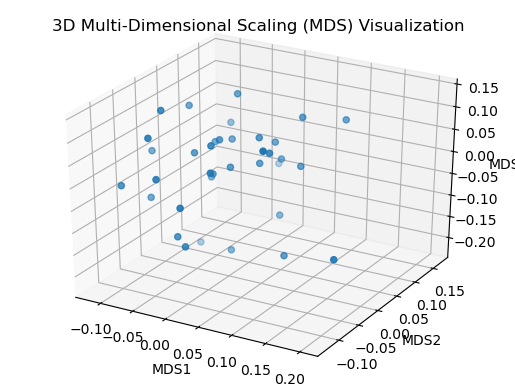

Cluster assignments: [0 0 0 0 0 0 1 1 1 0 1 0 1 0 1 0 1 1 0 0 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1]


InvalidParameterError: The 'eps' parameter of DBSCAN must be a float in the range (0.0, inf). Got array([0.07683231, 0.08134704, 0.08214327, 0.08333694, 0.08333694,
       0.08411538, 0.08521945, 0.08910885, 0.09049283, 0.09355645,
       0.09394946, 0.10182115, 0.1020674 , 0.10337318, 0.10374436,
       0.11168118, 0.11207994, 0.11387125, 0.11417669, 0.11468194,
       0.1191246 , 0.11961225, 0.12120875, 0.12590619, 0.12819446,
       0.13205397, 0.13432142, 0.14032312, 0.14434683, 0.14514125,
       0.15617006, 0.16191721, 0.16628059, 0.1671337 , 0.22235378,
       0.23082795]) instead.

In [8]:
from sklearn.cluster import KMeans
%matplotlib inline
for round_number, corr in corr_set:
    data = 1 - corr.reshape(-1, total_nums) - corr.reshape(-1, total_nums).T
    print(round_number, data.shape)
    # df=pd.DataFrame(data)
    # plot=seaborn.heatmap(df)
    # plt.show()
    # sns.heatmap(1-data)
    # plt.show()

    mds = MDS(n_components=3, dissimilarity='precomputed', random_state=1)
    mds_coords = mds.fit_transform(data)

    # 绘制3D图
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(mds_coords[:, 0], mds_coords[:, 1], mds_coords[:, 2])

    ax.set_xlabel('MDS1')
    ax.set_ylabel('MDS2')
    ax.set_zlabel('MDS3')
    plt.title('3D Multi-Dimensional Scaling (MDS) Visualization')
    plt.show()

    k = 2
    kmeans = KMeans(n_clusters=k, n_init=10)
    kmeans.fit(data)
    labels_kmeans = kmeans.labels_


    
    print("Cluster assignments:", labels_kmeans)

    dbscan = DBSCAN(eps=k_distance(data,5), min_samples=5, metric='precomputed')
    labels_dbscan = dbscan.fit_predict(data)
    
    gmm = GaussianMixture(n_components=10, random_state=0)



